# Deep Neural Network in TensorFlow

This is an example of a fully-connected feed-forward neural network implemented in TensorFlow 2.x without relying on Keras, except for tf.keras.Model, tf.keras.layers.Layer and tf.keras.layers.RandomRotation

This implementation has custom "dense", "flatten" and "dropout" layers. EarlyStopping, Adam and the loss function are all implemented from scratch. Finally, the training loop is also made explicit.

An hyperparameter optimization is also done using grid search.

## Load dependencies

In [211]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import copy
import random

## Set Seeds

In [212]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Load data

In [160]:
ds_train, ds_val = tfds.load(
  'mnist',
  split=['train', 'test'],
  shuffle_files=True,
  as_supervised=True,  # returns a tuple (img, label)
)

In [161]:
# Print the number of training images
train_size = tf.data.experimental.cardinality(ds_train)
print("Number of training images:", train_size.numpy())

Number of training images: 60000


In [162]:
# Print the number of validation images
val_size = tf.data.experimental.cardinality(ds_val)
print("Number of validation images:", val_size.numpy())

Number of validation images: 10000


## Set hyperparameters of the deep nueral network

In [163]:
lr = 0.001  # learning_rate
epochs = 30
batch_size = 256

## Set the architecture of the deep neural network

In [164]:
architecture = {
  'n_input': 784,
  'n_dense_1': 512,
  'n_classes': 10,
  'dropout_rate': 0.25,
  'rotation_factor': 0.1
}

## Preprocess the images (normalize, shuffle, batch, etc)

In [165]:
# Define the preprocessing function
def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.divide(image, 255.0)
  label = tf.one_hot(label, depth=architecture['n_classes'])  # One-hot encoding
  return image, label

# Apply preprocessing to the datasets and shuffle and batch
ds_train = ds_train.map(preprocess).shuffle(10000).batch(batch_size, drop_remainder=True)
ds_val = ds_val.map(preprocess).batch(batch_size, drop_remainder=True)

In [166]:
# Compute the mean and standard deviation of the pixel values in the training dataset
num_samples = 0
sum_pixels = 0.0
sum_pixels_squared = 0.0

for image, _ in ds_train:
    num_samples += 1
    sum_pixels += tf.reduce_sum(tf.cast(image, tf.float32))
    sum_pixels_squared += tf.reduce_sum(tf.square(tf.cast(image, tf.float32)))

mean_train = sum_pixels / (batch_size * num_samples * 28 * 28)
stddev_train = tf.sqrt(sum_pixels_squared / (batch_size * num_samples * 28 * 28) - tf.square(mean_train))
mean_train = mean_train.numpy()
stddev_train = stddev_train.numpy()

In [167]:
# Define the normalization preprocessing function
def preprocess(image, label):
  image = (image - mean_train) / stddev_train
  return image, label

# Apply normalization to the training dataset
ds_train = ds_train.map(preprocess)

In [168]:
# Compute the mean and standard deviation of the pixel values in the validation dataset
num_samples = 0
sum_pixels = 0.0
sum_pixels_squared = 0.0

for image, _ in ds_val:
    num_samples += 1
    sum_pixels += tf.reduce_sum(tf.cast(image, tf.float32))
    sum_pixels_squared += tf.reduce_sum(tf.square(tf.cast(image, tf.float32)))

mean_val = sum_pixels / (batch_size * num_samples * 28 * 28)
stddev_val = tf.sqrt(sum_pixels_squared / (batch_size * num_samples * 28 * 28) - tf.square(mean_val))
mean_val = mean_val.numpy()
stddev_val = stddev_val.numpy()

In [169]:
# Define the normalization preprocessing function
def preprocess(image, label):
  image = (image - mean_val) / stddev_val
  return image, label

# Apply normalization to the validation dataset
ds_val = ds_val.map(preprocess)

## Define the layers

In [170]:
class DenseLayer(tf.keras.layers.Layer):
  def __init__(self, units=64):
    super(DenseLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                              initializer='random_normal',
                              trainable=True,
                              name='w')
    self.b = self.add_weight(shape=(self.units,),
                              initializer='zeros',
                              trainable=True,
                              name='b')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

In [171]:
class DropoutLayer(tf.keras.layers.Layer):
  def __init__(self, rate, seed = 42):
    super(DropoutLayer, self).__init__()
    self.rate = rate
    self.seed = rate

  def call(self, x, training):
    if training:
      return tf.nn.dropout(x, rate=self.rate, seed=self.seed)
    return x

In [172]:
class FlattenLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(FlattenLayer, self).__init__()

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    flattened_shape = tf.stack([input_shape[0], input_shape[1] * input_shape[2]])
    return tf.reshape(inputs, flattened_shape)

## Design the deep neural network

In [173]:
class EarlyStopping():
  def __init__(self, min_delta, patience, restore_best_weights=True, verbosity=0):
    self.min_delta = min_delta
    self.patience = patience
    self.restore_best_weights = restore_best_weights
    self.best_val_loss = float('inf')
    self.wait = 0
    self.best_weights = None
    self.verbosity = verbosity

  def on_epoch_end(self, epoch, model, val_loss):
    if (self.best_val_loss - val_loss) > self.min_delta:
      if self.verbosity:
        print(f'Saving model weights from epoch: {epoch+1}')
      self.best_val_loss = val_loss
      self.wait = 0
      self.best_weights = model.get_weights()
      # Save the best model to a file
      model.save_weights('best_model_checkpoint.h5')
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'Early stopping at epoch {epoch+1}')
        return 1
    return 0

  def on_train_end(self, model):
    if self.restore_best_weights:
      model.set_weights(self.best_weights)

In [207]:
class Model(tf.keras.Model):
  def __init__(self, architecture, verbosity=1):
    super(Model, self).__init__()
    self.flatten = FlattenLayer()
    self.dropout = DropoutLayer(architecture['dropout_rate'])
    self.dense1 = DenseLayer(architecture['n_dense_1'])
    if 'n_dense_2' in architecture:
      self.dense2 = DenseLayer(architecture['n_dense_2'])
      if 'n_dense_3' in architecture:
        self.dense3 = DenseLayer(architecture['n_dense_3'])
    self.out_layer = DenseLayer(architecture['n_classes'])
    self.verbosity = verbosity
    if architecture['rotation_factor'] != 0:
      self.rotate = tf.keras.layers.RandomRotation(architecture['rotation_factor'], seed=42)
    else:
      self.rotate = None

  def call(self, inputs, training=False):
    """ Forward pass """
    if self.rotate is not None:
      x = self.rotate(inputs, training)
      x = self.flatten(x)
    else:
      x = self.flatten(inputs)
    x = tf.nn.relu(self.dense1(x))
    x = self.dropout(x, training)
    if hasattr(self, 'dense2'):
      x = tf.nn.relu(self.dense2(x))
      x = self.dropout(x, training)
      if hasattr(self, 'dense3'):
        x = tf.nn.relu(self.dense3(x))
        x = self.dropout(x, training)
    return self.out_layer(x)

  def compile(self, input_shape, loss, optimizer) -> None:
    # Build the model to ensure all variables are created
    self.build(input_shape)
    # Set loss function and optimizer
    self.loss_fn = loss
    self.optimizer = optimizer
    # Explicitly call self.optimizer.build() with the full list of trainable variables
    self.optimizer.build(self.trainable_variables)

  def train_step(self, data):
    """ Train the model and return loss and accuracy """
    train_loss = 0.0
    train_accuracy = 0.0
    n_batches = len(data)
    total_images = 0
    # Loop over batches
    for images, labels in data:
      with tf.GradientTape() as tape:
        logits = self(images, training=True)
        loss = self.loss_fn(labels, logits)
        train_loss += loss
        train_accuracy += tf.reduce_sum(tf.cast(tf.argmax(logits, axis=1) == tf.argmax(labels, axis=1), tf.float32))
        total_images += tf.cast(tf.shape(images)[0], tf.float32)  # append number of images in this batch
      # Calculate gradients
      gradients = tape.gradient(loss, self.trainable_variables)
      # Use gradients to update weights/biases
      self.optimizer.apply_gradients(gradients, self.trainable_variables)
    train_loss /= n_batches
    train_accuracy /= total_images
    return train_loss, train_accuracy

  def val_step(self, data):
    """ Evaluate the model and return loss and accuracy """
    val_loss = 0.0
    val_accuracy = 0.0
    n_batches = len(data)
    total_images = 0
    # Loop over batches
    for images, labels in data:
      logits = self(images, training=False)
      batch_loss = self.loss_fn(labels, logits)
      val_loss += batch_loss
      val_accuracy += tf.reduce_sum(tf.cast(tf.argmax(logits, axis=1) == tf.argmax(labels, axis=1), tf.float32))
      total_images += tf.cast(tf.shape(images)[0], tf.float32)  # append number of images in this batch
    val_loss /= n_batches
    val_accuracy /= total_images
    return val_loss, val_accuracy

  def eval(self, data):
    # Evaluate the model and measure the accuracy
    accuracy = 0.0
    total_images = 0
    for images, labels in data:
      logits = self(images, training=False)
      accuracy += tf.reduce_sum(tf.cast(tf.argmax(logits, axis=1) == tf.argmax(labels, axis=1), tf.float32))
      total_images += tf.cast(tf.shape(images)[0], tf.float32)  # append number of images in this batch
    accuracy /= total_images
    return accuracy

  def predict(self, data):
    # Evaluate the model and get predictions
    predictions = []
    for images, labels in data:
      logits = self(images, training=False)
      predictions.extend(tf.argmax(logits, axis=1).numpy())
    predictions = np.array(predictions)
    return predictions

  def train(self, epochs, train_data, val_data, callbacks):
    if self.verbosity: print(f'Will train for {epochs} epochs...')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
      train_loss, train_accuracy = self.train_step(train_data)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Evaluate the model in val data
      if val_data is not None:
        val_loss, val_accuracy = self.val_step(val_data)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if self.verbosity: print(f'Epoch {epoch+1}, train_loss: {train_loss}, val_loss: {val_loss}, val_acc: {val_accuracy}')
      else:  # no validation data was provided
        if self.verbosity: print(f'Epoch {epoch+1}, train_loss: {train_loss}, train_accuracy: {train_accuracy}')

      # Run callbacks at end of epoch
      if sum([callback.on_epoch_end(epoch, self, val_loss) for callback in callbacks]) > 0: break

    # Run callbacks at end of training
    for callback in callbacks:
      callback.on_train_end(self)

    return {
      'loss': train_losses,
      'accuracy': train_accuracies,
      'val_loss': val_losses,
      'val_accuracy': val_accuracies
    }

## Build model and define the loss and the optimizer

In [175]:
class CategoricalCrossentropy():
  def __init__(self, from_logits=False):
    self.from_logits = from_logits

  def __call__(self, y_true, y_pred):
    # Apply softmax to logits
    if self.from_logits:
      y_pred = tf.nn.softmax(y_pred)

    # Avoid numerical instability by clipping values
    epsilon = np.finfo(np.float32).eps
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Compute cross-entropy loss
    loss = -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1))

    return loss

In [176]:
class Adam:
  def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.m = None  # 1st momentum estimate
    self.v = None  # 2nd momentum estimate
    self.t = 0  # time step

  def build(self, params):
    # Necessary for compatibility
    pass

  def apply_gradients(self, gradients, params):
    if self.m is None:
      self.m = [tf.zeros_like(param) for param in params]
      self.v = [tf.zeros_like(param) for param in params]

    self.t += 1
    lr_t = self.learning_rate * tf.math.sqrt(1 - tf.math.pow(self.beta2, self.t)) / (1 - tf.math.pow(self.beta1, self.t))

    for i, (param, grad) in enumerate(zip(params, gradients)):
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.math.square(grad)
      param.assign_sub(lr_t * self.m[i] / (tf.math.sqrt(self.v[i]) + self.epsilon))

In [177]:
# Create an instance of my model and compile it
model = Model(architecture)
model.compile(
  input_shape = (None, 28, 28),
  loss = CategoricalCrossentropy(from_logits=True),  # from_logits=True since I'm not using softmax in last layer
  optimizer = Adam(learning_rate = lr)
)

## Define the parameters for early stopping

In [178]:
class EarlyStopping():
  def __init__(self, min_delta, patience, restore_best_weights=True, verbosity=0):
    self.min_delta = min_delta
    self.patience = patience
    self.restore_best_weights = restore_best_weights
    self.best_val_loss = float('inf')
    self.wait = 0
    self.best_weights = None
    self.verbosity = verbosity

  def on_epoch_end(self, epoch, model, val_loss):
    if (self.best_val_loss - val_loss) > self.min_delta:
      if self.verbosity:
        print(f'Saving model weights from epoch: {epoch+1}')
      self.best_val_loss = val_loss
      self.wait = 0
      self.best_weights = model.get_weights()
      # Save the best model to a file
      model.save_weights('best_model_checkpoint.h5')
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'Early stopping at epoch {epoch+1}')
        return 1
    return 0

  def on_train_end(self, model):
    if self.restore_best_weights and self.best_weights:
      model.set_weights(self.best_weights)

In [179]:
# Define parameters for early stopping
min_delta = 0.005
patience = 5
restore_best_weights = True

## Train the model

# **Play with archicture and batch size to reach closer to 100% accuracy in val data**

Hyperparameter optimization?

In [180]:
callbacks = [
  EarlyStopping(
    min_delta = min_delta,
    patience = patience,
    restore_best_weights = restore_best_weights,
    verbosity = 0
  )
]

In [181]:
history = model.train(epochs, ds_train, ds_val, callbacks)

Will train for 30 epochs...
Epoch 1, train_loss: 0.4288146495819092, val_loss: 0.1835491955280304, val_acc: 0.9432091116905212
Epoch 2, train_loss: 0.2092401683330536, val_loss: 0.12148957699537277, val_acc: 0.9645432829856873
Epoch 3, train_loss: 0.16315823793411255, val_loss: 0.09740772843360901, val_acc: 0.9710536599159241
Epoch 4, train_loss: 0.1400875449180603, val_loss: 0.09081103652715683, val_acc: 0.9731570482254028
Epoch 5, train_loss: 0.1271609663963318, val_loss: 0.08499396592378616, val_acc: 0.9749599099159241
Epoch 6, train_loss: 0.117369145154953, val_loss: 0.07600681483745575, val_acc: 0.9764623641967773
Epoch 7, train_loss: 0.11178998649120331, val_loss: 0.07251107692718506, val_acc: 0.9784655570983887
Epoch 8, train_loss: 0.1033596396446228, val_loss: 0.06921477615833282, val_acc: 0.9791666865348816
Epoch 9, train_loss: 0.09946200996637344, val_loss: 0.06329432129859924, val_acc: 0.9802684187889099
Epoch 10, train_loss: 0.09399347752332687, val_loss: 0.0625012218952179

## Plot the loss and the accuracy

In [182]:
def plot_loss(loss_dict) -> None:
    """ Plot loss and val_loss """
    # Get losses
    losses = loss_dict['loss']
    val_losses = loss_dict['val_loss']
    # Plot them
    plt.figure('loss')
    plt.plot(losses, label='loss', c='black')
    plt.plot(val_losses, label='val_loss', c='red')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

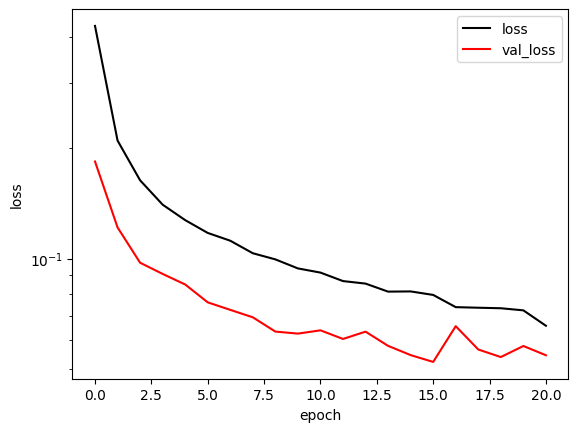

In [183]:
plot_loss(history)

In [184]:
def plot_acc(acc_dict) -> None:
    """ Plot acc and acc_loss """
    # Get accuracies
    acc = acc_dict['accuracy']
    val_acc = acc_dict['val_accuracy']
    # Plot them
    plt.figure('acc')
    plt.plot(acc, label='accuracy', c='black')
    plt.plot(val_acc, label='val_accuracy', c='red')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

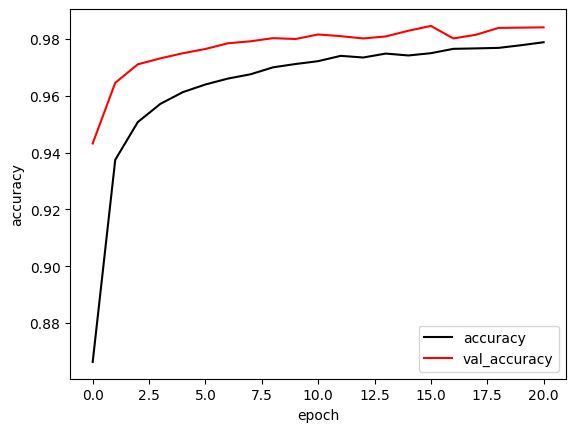

In [185]:
plot_acc(history)

## Evaluate the model in test data

Note: I will use the validation dataset, but in a real-scenario a different dataset should be used

In [186]:
# Evaluate the model in val data
test_accuracy = model.eval(ds_val)

print(f'Accuracy in test data: {test_accuracy}')

Accuracy in test data: 0.9845753312110901


In [187]:
# Get predictions for val data
predictions = model.predict(ds_val)

In [188]:
print(predictions)

[2 0 4 ... 3 1 6]


In [189]:
# Get target labels from test data
test_labels = []
for images, labels in ds_val:
  test_labels.extend(tf.argmax(labels, axis=1).numpy())
test_labels = np.array(test_labels)
print(test_labels)

[2 0 4 ... 3 1 6]


In [190]:
def plot_confusion_matrix(cm):
  ax = sns.heatmap(cm, annot=True)
  ax.set_title('x-axis: predicted labels, y-axis: true labels')
  ax.get_figure().savefig('confusion_matrix.png')

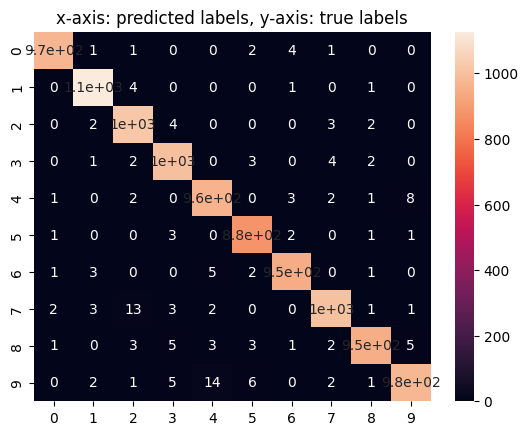

In [191]:
# Calculate and plot confusion matrix
# cm = confusion_matrix(to_numerical(data_dict['testing'][1]), labels_predicted)
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm)

# Hyperparameter optimization using grid search

Hyperparameters to optimize:
- Dropout: [0.15, 0.2, 0.25]
- Batch size: [100, 200, 300, 400, 500]
- Number of layers: [1, 2, 3]
- Number of neurons by layer [[60, 120, 240, 500], [50, 60, 120, 250], [25, 30, 60, 125]]
- learning rate: [0.01, 0.001, 0.005]

epochs: 15 w/ Early Stopping

In [195]:
# Define the preprocessing function
def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.divide(image, 255.0)
  label = tf.one_hot(label, depth=10)  # One-hot encoding
  return image, label

# Define the normalization preprocessing function
def normalize_train(image, label):
  image = (image - mean_train) / stddev_train
  return image, label

# Define the normalization preprocessing function
def normalize_val(image, label):
  image = (image - mean_val) / stddev_val
  return image, label

# Grid search
dropout_rates = [0.15, 0.2, 0.25, 0.5]
batch_sizes = [100, 200, 300, 500, 650]
n_layer_options = [1, 2, 3]
n_neurons_per_layer = [[60, 120, 240, 500, 600], [50, 60, 120, 250, 300], [25, 30, 60, 125, 150]]
learning_rates = [0.01, 0.001, 0.005, 0.0001]

# Get the data
data_train, data_val = tfds.load(
  'mnist',
  split=['train', 'test'],
  shuffle_files=True,
  as_supervised=True,  # returns a tuple (img, label)
)

# Function to rebuild dataset
def rebuild_dataset(dataset, preprocess_fn, normalize_fn, shuffle_seed=None, batch_size=None):
    dataset = dataset.map(preprocess_fn)
    if shuffle_seed is not None:
      dataset = dataset.shuffle(shuffle_seed)
    if batch_size is not None:
      dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(normalize_fn)
    return dataset

# Hyperparameter optimization
best_accuracy = 0
best_hyperparameters = {}
epochs = 30
counter = 0
for dropout_rate in dropout_rates:
  for batch_size in batch_sizes:
    for n_layers in n_layer_options:
      for i_option in range(len(n_neurons_per_layer[0])):
        n_neurons_layer_1 = n_neurons_per_layer[0][i_option]
        n_neurons_layer_2 = n_neurons_per_layer[1][i_option]
        n_neurons_layer_3 = n_neurons_per_layer[2][i_option]
        for learning_rate in learning_rates:
          counter +=1
          print(f'Training option {counter}...')
          # Prepare the data
          ds_train = rebuild_dataset(data_train, preprocess, normalize_train, 10000, batch_size)
          ds_val = rebuild_dataset(data_val, preprocess, normalize_val, None, batch_size)
          # Training preparations
          architecture = {
            'n_input': 784,
            'n_dense_1': n_neurons_layer_1,
            'n_classes': 10,
            'dropout_rate': dropout_rate,
            'rotation_factor': 0.1
          }
          if n_layers > 1:
            architecture['n_dense_2'] = n_neurons_layer_2
            if n_layers > 2:
              architecture['n_dense_3'] = n_neurons_layer_3
          # Create an instance of my model and compile it
          model = Model(architecture, verbosity=0)
          model.compile(
            input_shape = (None, 28, 28),
            loss = CategoricalCrossentropy(from_logits=True),  # from_logits=True since I'm not using softmax in last layer
            optimizer = Adam(learning_rate = learning_rate)
          )
          # Train model
          callbacks = [
            EarlyStopping(
              min_delta = min_delta,
              patience = patience,
              restore_best_weights = restore_best_weights,
              verbosity = 0
            )
          ]
          history = model.train(epochs, ds_train, ds_val, callbacks)
          # Evaluate the model in val data
          test_accuracy = model.eval(ds_val)
          # Find best hyperparameters
          if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            print(f"  Best accuracy: {best_accuracy}")
            print(f"  Dropout rate: {dropout_rate}")
            print(f"  Batch size: {batch_size}")
            print(f"  Learning rate: {learning_rate}")
            print(f"  Number of layers: {n_layers}")
            print(f"  Neurons: [{n_neurons_layer_1}, {n_neurons_layer_2}, {n_neurons_layer_3}]")
            best_hyperparameters['dropout_rate'] = dropout_rate
            best_hyperparameters['batch_size'] = batch_size
            best_hyperparameters['n_layers'] = n_layers
            best_hyperparameters['n_neurons_per_layer'] = [n_neurons_layer_1]
            if n_layers > 1:
              best_hyperparameters['n_neurons_per_layer'] += [n_neurons_layer_2]
              if n_layers > 2:
                best_hyperparameters['n_neurons_per_layer'] += [n_neurons_layer_3]
            best_hyperparameters['learning_rate'] = learning_rate

Training option 1...
Early stopping at epoch 24
  Best accuracy: 0.9700000286102295
  Dropout rate: 0.2
  Batch size: 200
  Learning rate: 0.001
  Number of layers: 1
  Neurons: [60, 50, 25]
Training option 2...
Early stopping at epoch 19
  Best accuracy: 0.9772999882698059
  Dropout rate: 0.2
  Batch size: 200
  Learning rate: 0.001
  Number of layers: 1
  Neurons: [120, 60, 30]
Training option 3...
Early stopping at epoch 23
  Best accuracy: 0.9815000295639038
  Dropout rate: 0.2
  Batch size: 200
  Learning rate: 0.001
  Number of layers: 1
  Neurons: [240, 120, 60]
Training option 4...
Early stopping at epoch 15
Training option 5...
Early stopping at epoch 16
Training option 6...
Early stopping at epoch 21
Training option 7...
Early stopping at epoch 23
Training option 8...
Early stopping at epoch 14
Training option 9...
Early stopping at epoch 12
Training option 10...
Early stopping at epoch 15
Training option 11...
Early stopping at epoch 25
Training option 12...
Early stopping a

In [222]:
# Prepare the data
batch_size = 300
ds_train = rebuild_dataset(data_train, preprocess, normalize_train, 10000, batch_size)
ds_val = rebuild_dataset(data_val, preprocess, normalize_val, None, batch_size)

# Create an instance of my model and compile it
learning_rate = 0.001
architecture = {
  'n_input': 784,
  'n_dense_1': 600,
  'n_dense_2': 300,
  'n_classes': 10,
  'dropout_rate': 0.2,
  'rotation_factor': 0.1
}
model = Model(architecture, verbosity=1)
model.compile(
  input_shape = (None, 28, 28),
  loss = CategoricalCrossentropy(from_logits=True),  # from_logits=True since I'm not using softmax in last layer
  optimizer = Adam(learning_rate = learning_rate)
)
callbacks = [
  EarlyStopping(
    min_delta = min_delta,
    patience = patience,
    restore_best_weights = restore_best_weights,
    verbosity = 0
  )
]
epochs = 3
history = model.train(epochs, ds_train, ds_val, callbacks)
test_accuracy = model.eval(ds_val)
print(f'{test_accuracy = }')

Will train for 3 epochs...
Epoch 1, train_loss: 0.4165040850639343, val_loss: 0.15193510055541992, val_acc: 0.9536363482475281
Epoch 2, train_loss: 0.19438306987285614, val_loss: 0.1063937321305275, val_acc: 0.966464638710022
Epoch 3, train_loss: 0.1537170559167862, val_loss: 0.09250553697347641, val_acc: 0.9702020287513733
test_accuracy = <tf.Tensor: shape=(), dtype=float32, numpy=0.970202>


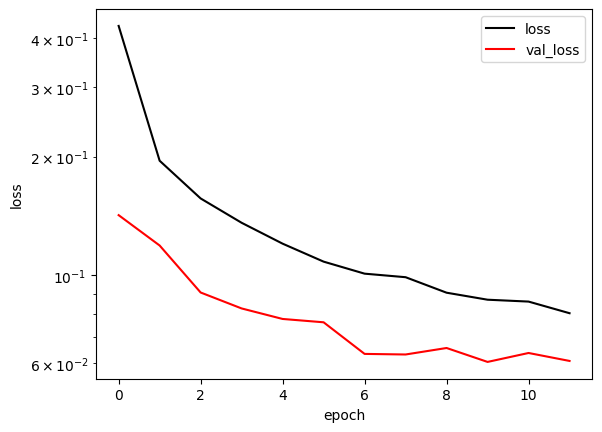

In [216]:
plot_loss(history)

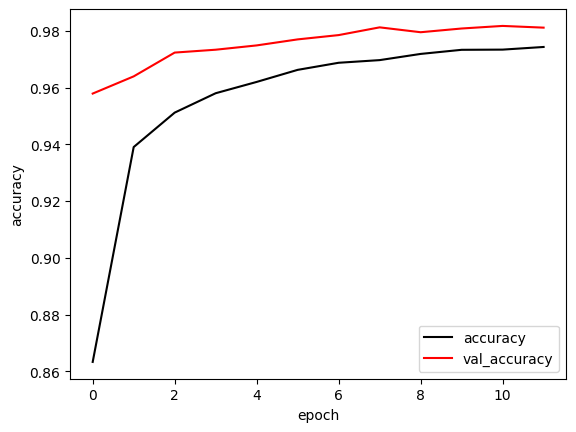

In [217]:
plot_acc(history)

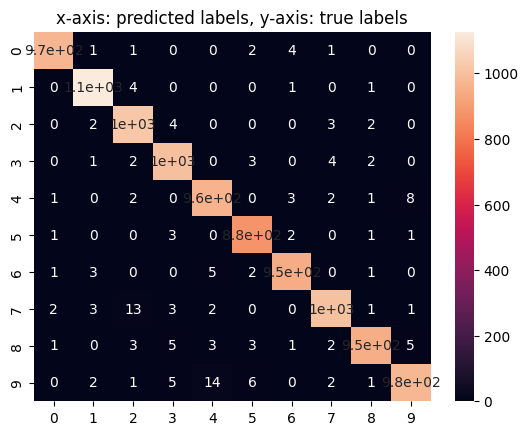

In [218]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm)